In [2]:
import pandas as pd
import numpy as np
import ast
from utils.utils import *
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from utils.generate_dfs import *
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


## Loading dataframes

In [3]:
similarities_df = pd.read_csv('csvs/similarities.csv', index_col=0)
videos_df = pd.read_csv('csvs/videos_df.csv', index_col=0)
embeddings_df = pd.read_csv('csvs/embeddings.csv', index_col=0)

In [4]:
embeddings_df.head()

,embedding_bert,embedding_mean_bert,embedding_hf
video_name,,,
DeepMind’s New AI: Assistant From The Future!,[[-4.11230952e-01 -3.07224512e-01 -1.23091914e...,[[-3.52466732e-01 -1.83229193e-01 4.56772596e...,[[-8.32884908e-02 -2.69665681e-02 3.02182939e...
Blender 4.1 - Create Virtual Worlds…For Free!,[[-9.96123999e-02 -3.39044273e-01 1.06826290e...,[[-4.75290045e-02 -1.54082075e-01 3.72303486e...,[[-3.85681652e-02 -2.80849040e-02 1.88307725e...
OpenAI Sora: Beauty And Horror!,[[-2.82204866e-01 -3.54010582e-01 -1.87018469e...,[[-7.50496238e-02 -1.62728757e-01 -4.48983237e...,[[-1.60020869e-02 2.15904936e-02 -1.71286725e...
OpenAI Sora Just Supercharged Filmmaking!,[[-1.08210146e-01 -2.12061957e-01 -6.52528554e...,[[-3.20733823e-02 -8.55088532e-02 1.85163632e...,[[-2.0056270e-02 -5.4418176e-02 -5.3889085e-02...
NVIDIA GTC: This Is The Future Of Everything!,[[-2.22307026e-01 -1.91042021e-01 -8.92981701e...,[[-2.48398125e-01 -3.30316648e-03 3.16924781e...,[[-7.43744001e-02 -1.52557064e-03 -1.84742920e...


In [5]:
similarities_df.columns

Index(['prompt', 'similarity_bert', 'similarity_hf', 'similarity_mean_bert'], dtype='object')

In [6]:
similarities_df.head()
columns_to_convert = ['similarity_bert', 'similarity_mean_bert', 'similarity_hf']
for column in columns_to_convert:
    similarities_df[column] = similarities_df[column].apply(ast.literal_eval)

## Exploring the different embeddings

### Closest video

In [7]:
i = 2
relevant_row = similarities_df.iloc[i]
similarities_df.index[i]

'OpenAI Sora: Beauty And Horror!'

In [8]:
type(relevant_row['similarity_bert'])

list

In [9]:
# Create a dataframe with all the correct/incorrect predictions
predictions = pd.DataFrame(columns=['video_id', 'bert', 'hf', 'mean_bert'])
video_names = similarities_df.index.tolist()

for i in range(len(similarities_df.index)):
    bert = hf = mean_bert = 0

    similarities_bert = similarities_df.iloc[i]['similarity_bert']
    similarities_hf = similarities_df.iloc[i]['similarity_hf']
    similarities_mean_bert = similarities_df.iloc[i]['similarity_mean_bert']

    closest_index_bert = np.argmax(similarities_bert)
    closest_index_hf = np.argmax(similarities_hf)
    closest_index_mean_bert = np.argmax(similarities_mean_bert)

    if video_names[closest_index_bert] == video_names[i]:
        bert = 1
    if video_names[closest_index_hf] == video_names[i]:
        hf = 1
    if video_names[closest_index_mean_bert] == video_names[i]:
        mean_bert = 1

    predictions.loc[i] = [video_names[i], bert, hf, mean_bert]

In [10]:
print(f"Accuracy Bert: {predictions['bert'].sum() / len(similarities_df.index) * 100:.2f}%")
print(f"Accuracy HF: {predictions['hf'].sum() / len(similarities_df.index) * 100:.2f}%")
print(f"Accuracy Mean Bert: {predictions['mean_bert'].sum() / len(similarities_df.index) * 100:.2f}%")

Accuracy Bert: 1.60%
Accuracy HF: 56.62%
Accuracy Mean Bert: 23.97%


### Closest N videos

In [11]:
num_videos = len(similarities_df.index)

# Initialize matrices to hold the top 3 indicators for each method
top_n_matrix_bert = np.zeros((num_videos, num_videos))
top_n_matrix_hf = np.zeros((num_videos, num_videos))
top_n_matrix_mean_bert = np.zeros((num_videos, num_videos))

In [12]:
predictions = pd.DataFrame(columns=['video_id', 'bert', 'hf', 'mean_bert'])
video_names = similarities_df.index.tolist()
n_top_samples = 1

for i in range(len(similarities_df.index)):
    bert = 0
    hf = 0
    mean_bert = 0

    relevant_row = similarities_df.iloc[i]
    similarities_bert = relevant_row['similarity_bert']
    similarities_hf = relevant_row['similarity_hf']
    similarities_mean_bert = relevant_row['similarity_mean_bert']

    # Get indices of the top 3 videos by similarity for each method
    top3_indices_bert = np.argsort(similarities_bert)[-n_top_samples:][::-1]
    top3_indices_hf = np.argsort(similarities_hf)[-n_top_samples:][::-1]
    top3_indices_mean_bert = np.argsort(similarities_mean_bert)[-n_top_samples:][::-1]

    # Fill the matrices for top 3 indicators
    top_n_matrix_bert[i, top3_indices_bert] = 1
    top_n_matrix_hf[i, top3_indices_hf] = 1
    top_n_matrix_mean_bert[i, top3_indices_mean_bert] = 1

    # Check if the current video is among the top 3 for each method
    if video_names[i] in [video_names[idx] for idx in top3_indices_bert]:
        bert = 1
    if video_names[i] in [video_names[idx] for idx in top3_indices_hf]:
        hf = 1
    if video_names[i] in [video_names[idx] for idx in top3_indices_mean_bert]:
        mean_bert = 1

    predictions = predictions._append({'video_id': video_names[i], 'bert': bert, 'hf': hf, 'mean_bert': mean_bert}, ignore_index=True)

In [13]:
print(f"Accuracy Bert: {predictions['bert'].sum() / len(similarities_df.index) * 100:.2f}%")
print(f"Accuracy HF: {predictions['hf'].sum() / len(similarities_df.index) * 100:.2f}%")
print(f"Accuracy Mean Bert: {predictions['mean_bert'].sum() / len(similarities_df.index) * 100:.2f}%")

Accuracy Bert: 1.60%
Accuracy HF: 56.62%
Accuracy Mean Bert: 23.97%


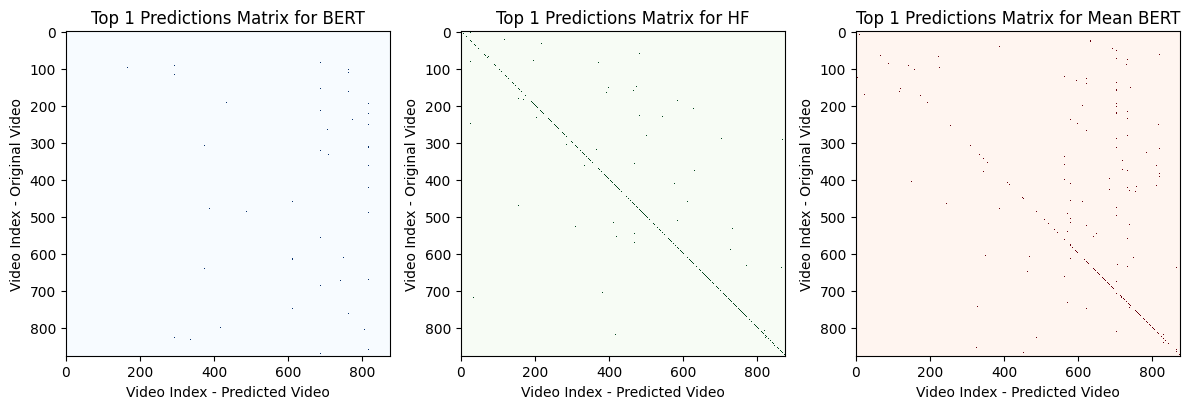

In [14]:
# Plotting the matrices
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

axes[0].imshow(top_n_matrix_bert, cmap='Blues', interpolation='nearest')
axes[0].set_title(f'Top {n_top_samples} Predictions Matrix for BERT')
axes[0].set_ylabel('Video Index - Original Video')
axes[0].set_xlabel('Video Index - Predicted Video')

axes[1].imshow(top_n_matrix_hf, cmap='Greens', interpolation='nearest')
axes[1].set_title(f'Top {n_top_samples} Predictions Matrix for HF')
axes[1].set_ylabel('Video Index - Original Video')
axes[1].set_xlabel('Video Index - Predicted Video')

axes[2].imshow(top_n_matrix_mean_bert, cmap='Reds', interpolation='nearest')
axes[2].set_title(f'Top {n_top_samples} Predictions Matrix for Mean BERT')
axes[2].set_ylabel('Video Index - Original Video')
axes[2].set_xlabel('Video Index - Predicted Video')

plt.tight_layout()
plt.show()

## For training

### Pre-Processing and model definition

In [15]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load the data
videos_df = pd.read_csv('csvs/videos_df.csv')

In [16]:
# Create a dataframe with all the correct/incorrect predictions
predictions = pd.DataFrame(columns=['video_id', 'hf'])
video_names = similarities_df.index.tolist()

for i in range(len(similarities_df.index)):
    hf = 0

    similarities_hf = similarities_df.iloc[i]['similarity_hf']

    closest_index_hf = np.argmax(similarities_hf)

    if video_names[closest_index_hf] == video_names[i]:
        hf = 1

    predictions.loc[i] = [video_names[i], hf]

print(f"Accuracy HF: {predictions['hf'].sum() / len(similarities_df.index) * 100:.2f}%")

Accuracy HF: 56.62%


In [17]:
videos_df = videos_df.drop(columns=['channel_name'])

In [18]:
embeddings_df = generate_embeddings_hf_df(videos_df, 'csvs/embeddings_hf.csv')
embeddings_df.head()

100%|██████████| 876/876 [00:29<00:00, 29.66it/s]


,video_name,title_embedding,desc_embedding,transcript_embedding,prompt_embedding,label
0,DeepMind’s New AI: Assistant From The Future!,"[[-0.12433333, -0.08009393, 0.03450345, 0.0180...","[[-0.011247036, 0.09796095, 0.03491168, 0.0456...","[[-0.1006035, -0.08105761, 0.01981136, -0.0274...","[[-0.11957101, -0.07976705, 0.030240418, -0.06...",0
1,Blender 4.1 - Create Virtual Worlds…For Free!,"[[0.0084991045, -0.040308878, 0.017153518, -0....","[[-0.09826999, 0.0056838603, -0.005567224, -0....","[[-0.04162269, -0.04555503, 0.045465104, -0.03...","[[0.0011685346, -0.08414962, -0.037104733, -0....",1
2,OpenAI Sora: Beauty And Horror!,"[[-0.022502398, -0.0004974325, -0.060733378, 0...","[[-0.011247036, 0.09796095, 0.03491168, 0.0456...","[[-0.012090054, -0.025329394, -0.011029416, -6...","[[-0.08760911, -0.01805747, -0.015938623, -0.0...",2
3,OpenAI Sora Just Supercharged Filmmaking!,"[[-0.03048498, -0.045707945, -0.09320625, 0.04...","[[0.024373285, -0.07085469, -0.015706317, 0.07...","[[-0.050580874, -0.049595285, -0.039648954, -0...","[[-0.033678133, -0.046196513, -0.015098083, -0...",3
4,NVIDIA GTC: This Is The Future Of Everything!,"[[-0.09338506, 0.0318434, -0.011997288, 0.0128...","[[-0.095089, -0.010089811, -0.010409337, -0.02...","[[-0.028312227, -0.03745329, -0.035175253, -0....","[[-0.037741415, -0.009634391, 0.0037468406, -0...",4


In [19]:
# Look into what an embedding looks like:
embeddings_df['title_embedding'][0].shape

(1, 384)

In [20]:
torch_emb = torch.tensor(embeddings_df['title_embedding'][0], dtype=torch.float32).squeeze()
torch_emb.shape

torch.Size([384])

In [21]:
class VideoRecommendationModel(nn.Module):
    def __init__(self, embed_dim):
        super(VideoRecommendationModel, self).__init__()
        self.embed_dim = embed_dim
        initial_weights = torch.tensor([0.3, 0.4, 0.3]).view(3, 1)  # Create a 3x1 tensor with the desired values
        self.weights = nn.Parameter(initial_weights)

    def forward(self, title_embeds, desc_embeds, trans_embeds, prompt_embed, relevant_indices):
        # Stack embeddings and ensure they are of shape [num_videos, 3, embed_dim]
        stacked_embeds = torch.stack([title_embeds, desc_embeds, trans_embeds], dim=1)

        # Apply softmax to weights to get normalized weights of shape [3, 1]
        weights = F.softmax(self.weights, dim=0)

        # Perform weighted sum by broadcasting weights across the embedding dimension
        weighted_embeds = stacked_embeds * weights.expand_as(stacked_embeds)

        # Sum across the second dimension (the one holding the three embedding types) to combine them
        joint_video_embeds = torch.sum(weighted_embeds, dim=1)

        # Normalize embeddings
        joint_video_embeds = F.normalize(joint_video_embeds, p=2, dim=1)
        prompt_embed = F.normalize(prompt_embed, p=2, dim=1)

        # Calculate cosine similarities
        cosine_similarities = torch.mm(joint_video_embeds, prompt_embed.t()).squeeze(1)  # Shape: [num_videos]

        # Filter cosine similarities based on relevant indices
        # relevant_cosine_similarities = cosine_similarities[relevant_indices]

        return cosine_similarities

In [22]:
title_embeds = torch.tensor(embeddings_df['title_embedding'], dtype=torch.float32).squeeze()
desc_embeds = torch.tensor(embeddings_df['desc_embedding'], dtype=torch.float32).squeeze()
trans_embeds = torch.tensor(embeddings_df['transcript_embedding'], dtype=torch.float32).squeeze()
prompt_embeds = torch.tensor(embeddings_df['prompt_embedding'], dtype=torch.float32)
relevant_indices = torch.tensor(embeddings_df['label'][:32], dtype=torch.long)
title_embeds.shape

C:\Users\eriki\AppData\Local\Temp\ipykernel_32008\2211027479.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  title_embeds = torch.tensor(embeddings_df['title_embedding'], dtype=torch.float32).squeeze()


torch.Size([876, 384])

In [23]:
# Instantiate the model
embed_dim = 384
model = VideoRecommendationModel(embed_dim)

In [24]:
prompt_embeds.shape

torch.Size([876, 1, 384])

In [25]:
# Forward pass through the model
cosine_similarities = model(title_embeds, desc_embeds, trans_embeds, prompt_embeds[0], relevant_indices)
# cosine_similarities = model(title_embeds, desc_embeds, trans_embeds, prompt_embeds[:32].squeeze(), relevant_indices)

# Output cosine similarities
print(type(cosine_similarities))

<class 'torch.Tensor'>


In [26]:
cosine_similarities.shape

torch.Size([876])

In [27]:
max_value, max_index = torch.max(cosine_similarities, 0)

In [28]:
int(max_index)
max_value

tensor(0.7507, grad_fn=<MaxBackward0>)

In [29]:
class VideoDataset(Dataset):
    def __init__(self, title_embeds, desc_embeds, trans_embeds, prompt_embeds, relevant_indices):
        """
        Initializes the dataset.
        
        :param title_embeds: Tensor of shape [num_samples, embed_dim] - embeddings for the titles
        :param desc_embeds: Tensor of shape [num_samples, embed_dim] - embeddings for the descriptions
        :param trans_embeds: Tensor of shape [num_samples, embed_dim] - embeddings for the transcripts
        :param prompt_embeds: Tensor of shape [num_samples, embed_dim] - embeddings for the prompts
        :param relevant_indices: Tensor of shape [num_samples] - index of the relevant video for each prompt
        """
        self.title_embeds = title_embeds
        self.desc_embeds = desc_embeds
        self.trans_embeds = trans_embeds
        self.prompt_embeds = prompt_embeds
        self.relevant_indices = relevant_indices

    def __len__(self):
        return len(self.prompt_embeds)

    def __getitem__(self, idx):
        # Return the embeddings along with the index of the relevant video
        return (self.title_embeds[idx], self.desc_embeds[idx], self.trans_embeds[idx],
                self.prompt_embeds[idx], self.relevant_indices[idx])


In [41]:
title_embeds = torch.tensor(embeddings_df['title_embedding'], dtype=torch.float32).squeeze()
desc_embeds = torch.tensor(embeddings_df['desc_embedding'], dtype=torch.float32).squeeze()
trans_embeds = torch.tensor(embeddings_df['transcript_embedding'], dtype=torch.float32).squeeze()
prompt_embeds = torch.tensor(embeddings_df['prompt_embedding'], dtype=torch.float32).squeeze()
relevant_indices = torch.tensor(embeddings_df['label'], dtype=torch.long)

# Instantiate the dataset
video_dataset = VideoDataset(title_embeds, desc_embeds, trans_embeds, prompt_embeds, relevant_indices)

# Setup the DataLoader to handle batching
batch_size = 32
video_dataloader = DataLoader(video_dataset, batch_size=batch_size, shuffle=True)


In [31]:
print(f'The dataset contains {len(video_dataset)} samples.')
print(f'The title embeddings have shape: {title_embeds.shape}')
print(f'The description embeddings have shape: {desc_embeds.shape}')
print(f'The transcript embeddings have shape: {trans_embeds.shape}')
print(f'The prompt embeddings have shape: {prompt_embeds.shape}')
print(f'The relevant indices have shape: {relevant_indices.shape}')

The dataset contains 876 samples.
The title embeddings have shape: torch.Size([876, 384])
The description embeddings have shape: torch.Size([876, 384])
The transcript embeddings have shape: torch.Size([876, 384])
The prompt embeddings have shape: torch.Size([876, 384])
The relevant indices have shape: torch.Size([876])


In [32]:
video_dataset.title_embeds.shape

torch.Size([876, 384])

### Initial results - No training

In [42]:
def initialize_model(embed_dim):
    model = VideoRecommendationModel(embed_dim=embed_dim)
    return model

# Create a dataframe with all the correct/incorrect predictions
# Setup the loss function
loss_function = nn.BCEWithLogitsLoss()

# Setup the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed
model = initialize_model(embed_dim)
predictions = pd.DataFrame(columns=['video_id', 'hf'])
cosine_similarities = model(title_embeds, desc_embeds, trans_embeds, prompt_embeds, relevant_indices)
video_names = similarities_df.index.tolist()
true_index = list(range(len(video_names)))
predicted_index = torch.argmax(cosine_similarities, dim=1).tolist()

print(f'Accuracy: {sum([1 for i, j in zip(true_index, predicted_index) if i == j]) / len(true_index) * 100:.2f}%')

Accuracy: 56.85%


### BCE Loss

#### Train

In [43]:
def train(model, optimizer, loss_function, dataloader, epochs):
    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        total_loss = 0
        for title_batch, desc_batch, trans_batch, prompt_batch, indices_batch in dataloader:
            current_batch_size = title_batch.shape[0]
            optimizer.zero_grad()  # Clear gradients

            # Forward pass: Compute the cosine similarities
            cosine_similarities = model(title_batch, desc_batch, trans_batch, prompt_batch, list(range(current_batch_size)))  # Shape: [batch_size, batch_size]
            
            # Create a target matrix where only the diagonal elements are 1
            targets = torch.eye(current_batch_size, dtype=torch.float32)

            # Compute loss
            loss = loss_function(cosine_similarities, targets)

            # Backpropagation
            loss.backward()

            # Update model parameters
            optimizer.step()

            total_loss += loss.item()

        # Optionally print average loss per epoch
        if (epoch + 1) % 10 == 0:
            average_loss = total_loss / len(dataloader)
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {average_loss:.4f}')

In [44]:
# Define the number of epochs
num_epochs = 500

# Call the train function
optimizer = optim.Adam(model.parameters())
train(model, optimizer, loss_function, video_dataloader, num_epochs)

Epoch [10/500], Average Loss: 0.8319
Epoch [20/500], Average Loss: 0.8264
Epoch [30/500], Average Loss: 0.8169
Epoch [40/500], Average Loss: 0.8114
Epoch [50/500], Average Loss: 0.8068
Epoch [60/500], Average Loss: 0.8057
Epoch [70/500], Average Loss: 0.8040
Epoch [80/500], Average Loss: 0.8041
Epoch [90/500], Average Loss: 0.8025
Epoch [100/500], Average Loss: 0.8024
Epoch [110/500], Average Loss: 0.8020
Epoch [120/500], Average Loss: 0.8022
Epoch [130/500], Average Loss: 0.8011
Epoch [140/500], Average Loss: 0.7998
Epoch [150/500], Average Loss: 0.8011
Epoch [160/500], Average Loss: 0.8008
Epoch [170/500], Average Loss: 0.8013
Epoch [180/500], Average Loss: 0.8002
Epoch [190/500], Average Loss: 0.8009
Epoch [200/500], Average Loss: 0.8006
Epoch [210/500], Average Loss: 0.8001
Epoch [220/500], Average Loss: 0.8003
Epoch [230/500], Average Loss: 0.8001
Epoch [240/500], Average Loss: 0.8001
Epoch [250/500], Average Loss: 0.8000
Epoch [260/500], Average Loss: 0.8001
Epoch [270/500], Aver

#### Evaluation

In [45]:
# Create a dataframe with all the correct/incorrect predictions
model.eval()  # Set the model to evaluation mode
predictions = pd.DataFrame(columns=['video_id', 'hf'])
cosine_similarities = model(title_embeds, desc_embeds, trans_embeds, prompt_embeds, relevant_indices)
video_names = similarities_df.index.tolist()

true_index = list(range(len(video_names)))
predicted_index = torch.argmax(cosine_similarities, dim=1).tolist()

print(f'Accuracy: {sum([1 for i, j in zip(true_index, predicted_index) if i == j]) / len(true_index) * 100:.2f}%')

Accuracy: 55.02%


Seems like the accuracy actually went LOWER, OMEGALUL

### Pairwise Ranking Loss

#### Train

In [46]:
def train(model, optimizer, dataloader, epochs):
    model.train()  # Set the model to training mode
    margin = 1.0  # Margin for ranking loss
    criterion = nn.MarginRankingLoss(margin=margin)

    for epoch in range(epochs):
        total_loss = 0
        for title_batch, desc_batch, trans_batch, prompt_batch, indices_batch in dataloader:
            current_batch_size = title_batch.shape[0]
            optimizer.zero_grad()  # Clear gradients

            # Forward pass: Compute the cosine similarities
            cosine_similarities = model(title_batch, desc_batch, trans_batch, prompt_batch, list(range(current_batch_size)))  # Shape: [batch_size, batch_size]
            
            # Compute the pairwise ranking loss
            loss = 0
            for i in range(current_batch_size):
                # Positive examples are the diagonal elements
                positive_examples = cosine_similarities[i, i].expand(current_batch_size - 1)
                # Negative examples are all non-diagonal elements in the row
                negative_examples = torch.cat([cosine_similarities[i, :i], cosine_similarities[i, i+1:]])
                # Targets: 1's indicating positive examples should have higher scores
                targets = torch.ones(current_batch_size - 1)
                loss += criterion(positive_examples, negative_examples, targets)

            loss /= current_batch_size  # Average the loss over the number of comparisons in the batch

            # Backpropagation
            loss.backward()

            # Update model parameters
            optimizer.step()

            total_loss += loss.item()

        # Optionally print average loss per epoch
        if (epoch + 1) % 10 == 0:
            average_loss = total_loss / len(dataloader)
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {average_loss:.4f}')



In [38]:
# Define the number of epochs
num_epochs = 100
model = initialize_model(embed_dim)
# Call the train function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, video_dataloader, num_epochs)

Epoch [10/100], Average Loss: 0.6178
Epoch [20/100], Average Loss: 0.6150
Epoch [30/100], Average Loss: 0.6156
Epoch [40/100], Average Loss: 0.6163
Epoch [50/100], Average Loss: 0.6185
Epoch [60/100], Average Loss: 0.6182
Epoch [70/100], Average Loss: 0.6169
Epoch [80/100], Average Loss: 0.6148
Epoch [90/100], Average Loss: 0.6163
Epoch [100/100], Average Loss: 0.6158


#### Evaluation

In [39]:
# Create a dataframe with all the correct/incorrect predictions
model.eval()  # Set the model to evaluation mode
predictions = pd.DataFrame(columns=['video_id', 'hf'])
cosine_similarities = model(title_embeds, desc_embeds, trans_embeds, prompt_embeds, relevant_indices)
video_names = similarities_df.index.tolist()

true_index = list(range(len(video_names)))
predicted_index = torch.argmax(cosine_similarities, dim=1).tolist()

print(f'Accuracy: {sum([1 for i, j in zip(true_index, predicted_index) if i == j]) / len(true_index) * 100:.2f}%')

Accuracy: 58.90%


In [40]:
model.weights

Parameter containing:
tensor([[-0.2028],
        [ 0.8368],
        [ 0.0283]], requires_grad=True)

## Next thing

In [34]:
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

MODEL = 'gemma:2b-instruct'
model = Ollama(model=MODEL)
embeddings = OllamaEmbeddings(model=MODEL)

model.invoke('tell me a joke')

'Why did the math book look so sad?\n\nBecause of all of its problems!'

In [35]:
from sentence_transformers import SentenceTransformer
encoding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

encoding = encoding_model.encode('Tell me a joke')

In [39]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from utils.utils import get_video_transcript

text_type = 'description'
model = Ollama(model=MODEL)
parser = StrOutputParser()
template = """
    Please summarize the video {text_type}. 
    Start your summary with the phrase "The video summary based on the {text_type} is:" 
    and provide the summary right after.

    text: {text}
    """

prompt = PromptTemplate.from_template(template)
chain = prompt | model | parser
text = get_video_transcript('3JZ_D3ELwOQ')
chain.invoke({"text":text, "text_type": text_type})

"**Video Summary:**\n\nThe video features a compilation of humorous clips featuring a man trying to gain muscle. The clips showcase various exercises, including bench pressing, koala bear workouts, and squirrel-related antics. The video highlights the man's impressive physique and the challenges he faces in achieving his fitness goals. It also includes a brief segment that explores the real-life implications of the video, addressing topics such as drug use and criminal activity."

In [25]:
def summarize_text(text, text_type, chain):
    return chain.invoke({"text": text, "text_type": text_type})

def process_summary(response: str, prefix: str) -> str:
    if prefix in response:
        summary_text = response.replace(prefix, "").strip()
        summary_text = summary_text.strip('*').strip()
        return summary_text
    else:
        return "Summary extraction error: Unexpected response format."

In [32]:
import pandas as pd

# Load the data
videos_df = pd.read_csv('csvs/videos_df.csv')

for i in range(5):
    print(f'Video name - {videos_df["video_name"][i]}\n')
    text = videos_df['video_description'][i]
    summary = summarize_text(text, 'description', chain)
    clean_summary = process_summary(summary, "The video summary based on the description is:")
    print(f'{clean_summary}')
    text2 = videos_df['video_transcript'][i]
    summary2 = summarize_text(text2, 'transcript', chain)
    clean_summary2 = process_summary(summary2, "The video summary based on the transcript is:")
    print(f'{clean_summary2}\n')

Video name - DeepMind’s New AI: Assistant From The Future!

The provided video description contains an error, indicating an unexpected response format. Further analysis is required to extract a meaningful summary.
The paper explores the potential of Google DeepMind's Gemini 1.5 Pro AI to perform various tasks, including weight lifting, code writing, and movie summarization. However, it acknowledges its significant limitations, such as its quadratic computational and memory complexity and accuracy degradation for long sequences of data. Despite these limitations, the paper highlights the impressive accuracy of GPT-4 Turbo, demonstrating its remarkable capabilities in language processing.

Video name - Blender 4.1 - Create Virtual Worlds…For Free!

The video explores the work of Andrew Price, an animator known for creating donut tutorials and a paper demonstrating simulations remarkably similar to reality. The video highlights the support of Patreon supporters who make Two Minute Papers 